In [1]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import os
import sys

In [2]:
import pmp_functions_v5 as pmp

In [3]:
# --- 1. DEFINE THE MISSING HELPER FUNCTION ---
def process_bloomberg_sheet(df, remove_header_rows=0):
    """
    Standard cleaning for Excel exports.
    1. Removes top N metadata rows.
    2. Finds the header row containing 'Date'.
    3. Resets index.
    """
    df = df.iloc[remove_header_rows:].copy()
    
    # Simple clean: Ensure we don't have empty rows at the top
    df = df.dropna(how='all')
    
    # If the first column isn't "Date", try to find the header
    # (This is a failsafe if headers are on row 3, for example)
    if "Date" not in df.columns:
        # Try to find the row that contains "Date"
        for i in range(min(10, len(df))):
            row_vals = df.iloc[i].astype(str).values
            if "Date" in row_vals:
                df.columns = df.iloc[i]
                df = df.iloc[i+1:]
                break
    
    return df


Loading ...
Loading ...
Loading ...
Loading ...

--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
   Realized Vol (Unscaled): 12.54%
   Scaling Factor: 0.80x

--- RUNNING STRATEGY: BOND ---
   Assets: 7
   Realized Vol (Unscaled): 5.68%
   Scaling Factor: 1.76x

--- RUNNING STRATEGY: RATES ---
   Assets: 7
   Realized Vol (Unscaled): 0.66%
   Scaling Factor: 3.00x

--- RUNNING STRATEGY: FX ---
   Assets: 6
   Realized Vol (Unscaled): 6.53%
   Scaling Factor: 1.53x

Final Portfolio Re-Scaling Factor: 1.95x

             PERFORMANCE SUMMARY PER ASSET CLASS       
                          Equity     Bond   Rates      FX  Total_Portfolio
Arithm Avg Total Return  -2.0963   0.8849  0.6133  1.7795           0.5755
Arithm Avg Xs Return     -4.0963  -1.1151 -1.3867 -0.2205          -1.4245
Std Xs Returns           10.0000  10.0780  1.9242  9.1131          10.0000
Sharpe Arithmetic        -0.4096  -0.1106 -0.7206 -0.0242          -0.1424
Geom Avg Total Return    -2.5753   0.3785  0.5965  1.3748   

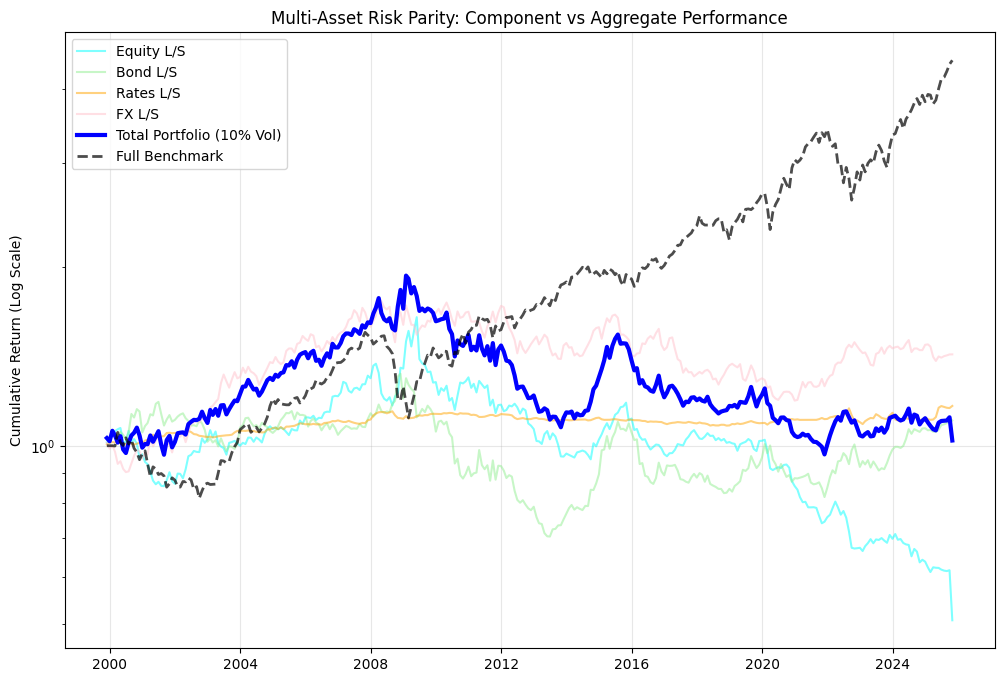

In [61]:
# =============================================================================
# --- CONFIGURATION & CONSTANTS ---
# =============================================================================

# Paths & Targets
VOL_TARGET = 0.10
DATA_PATH = '../Data/'

# Strategy Parameters
MOMENTUM_LOOKBACKS = [1, 3, 12]  # Months for signal generation
SIGNAL_LAG = 1                   # Lag to apply to signal
K_SELECT = 3                     # Number of assets to select (CS Momentum)
MIN_ASSETS = 4                   # Min assets required to trade

# Risk Management & Costs
RF_ANNUAL = 0.02                 # Assumed risk-free rate (2%)
T_COST_BPS = 0.0000              # Transaction costs (10 basis points)
MAX_SCALAR_STRATEGY = 3.0        # Max leverage cap for individual asset class
MAX_SCALAR_PORTFOLIO = 3.0       # Max leverage cap for final aggregated portfolio

# Time & Frequency
ANNUALIZATION_FACTOR = 12
RESAMPLE_FREQ = "ME"             # Month End

# Derived Constants
RF_MONTHLY = RF_ANNUAL / ANNUALIZATION_FACTOR
T_COST = T_COST_BPS              # Passing directly as decimal if pmp expects decimal, or bps if expected bps

# =============================================================================
# 1. THE STRATEGY FACTORY
# =============================================================================
def run_independent_strategy(name, df_prices, benchmark, k_select=K_SELECT, min_assets=MIN_ASSETS):
    """
    Runs a complete, isolated Momentum L/S strategy for a single asset class.
    """
    print(f"\n--- RUNNING STRATEGY: {name} ---")
    print(f"   Assets: {len(df_prices.columns)}")
    
    # A. Prepare Data
    returns = df_prices.pct_change().fillna(0)
    rf_series = pd.Series(RF_MONTHLY, index=returns.index, name="RF")
    
    # B. Signal Generation
    raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)
    
    for lag in MOMENTUM_LOOKBACKS:
        mom = df_prices.pct_change(lag)
        sig = np.sign(mom)
        raw_signal += sig
    
    final_signal = raw_signal / len(MOMENTUM_LOOKBACKS)
    
    # C. Weight Generation
    weights_unscaled = pmp.make_country_weights(
        signal=final_signal,
        returns=returns,
        benchmark_series=benchmark,
        k=k_select,            
        long_short=True,
        beta_neutral=False,    
        signal_lag=SIGNAL_LAG,
        min_regions=min_assets 
    )
    
    # D. Preliminary Backtest (Unscaled)
    # We use 0.0 cost here to get pure realized volatility for scaling
    res_unscaled = pmp.run_cc_strategy(
        weights=weights_unscaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0, 
        benchmark=benchmark
    )
    
    # E. Volatility Targeting
    ret_series = res_unscaled["ret_net"].dropna()
    realized_vol = ret_series.std() * np.sqrt(ANNUALIZATION_FACTOR)
    
    if realized_vol > 0:
        scalar = VOL_TARGET / realized_vol
        scalar = min(scalar, MAX_SCALAR_STRATEGY) 
    else:
        scalar = 1.0
        
    print(f"   Realized Vol (Unscaled): {realized_vol:.2%}")
    print(f"   Scaling Factor: {scalar:.2f}x")
    
    # F. Final Scaled Backtest
    weights_scaled = weights_unscaled * scalar
    res_final = pmp.run_cc_strategy(
        weights=weights_scaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=T_COST, 
        benchmark=benchmark
    )
    
    return res_final

# =============================================================================
# 2. DATA LOADING & PREPROCESSING
# =============================================================================

def load_and_process(filename, suffix, is_fx=False):
    """
    Helper to load and process data to avoid repetition.
    """
    print(f"Loading {suffix}...")
    full_path = os.path.join(DATA_PATH, filename)
    
    # Handle FX Returns vs Price data structure
    if is_fx:
        df = pd.read_excel(full_path, sheet_name="RETURNS", engine='openpyxl')
    else:
        df = pd.read_excel(full_path, engine='openpyxl')
        
    # Index setting
    if 'Date' in df.columns:
        df = df.set_index('Date')
    elif 'Dates' in df.columns:
        df = df.set_index('Dates')
    else:
        df = df.set_index(df.columns[0])
    
    df.index = pd.to_datetime(df.index, errors='coerce')
    
    # FX special handling
    if is_fx:
        df = (1 + df.fillna(0)).cumprod() * 100
    
    # Renaming and resampling
    df.columns = [f"{c}{suffix}" for c in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce').resample(RESAMPLE_FREQ).last().ffill()
    
    # Ensure data goes up to 2025-11-30
    target_date = pd.Timestamp("2025-11-30")
    if df.index[-1] != target_date:
        last_row = df.iloc[[-1]].copy()
        last_row.index = [target_date]
        df = pd.concat([df, last_row]).sort_index()
    
    return df

# --- Load Assets ---
df_eq = load_and_process("Equity Data.xlsx", "")
df_bd = load_and_process("Bond Data.xlsx", "")
df_rt = load_and_process("Interest Rates Data.xlsx", "")
df_fx = load_and_process("FX Data.xlsx", "", is_fx=True)

# --- Load Benchmark ---
df_bench = pd.read_excel(os.path.join(DATA_PATH, "Benchmarks.xlsx"), engine='openpyxl')
if 'Date' in df_bench.columns: df_bench = df_bench.set_index('Date')
else: df_bench = df_bench.set_index(df_bench.columns[0])
df_bench.index = pd.to_datetime(df_bench.index, errors='coerce')
df_bench = df_bench.resample(RESAMPLE_FREQ).last().ffill()
benchmark_ret = df_bench['Full Benchmark'].pct_change().fillna(0)

# =============================================================================
# 3. EXECUTION PER ASSET CLASS
# =============================================================================

ret_equity = run_independent_strategy("EQUITY", df_eq, benchmark=benchmark_ret)
ret_bond = run_independent_strategy("BOND", df_bd, benchmark=benchmark_ret)
ret_rates = run_independent_strategy("RATES", df_rt, benchmark=benchmark_ret)
ret_fx = run_independent_strategy("FX", df_fx, benchmark=benchmark_ret)

# =============================================================================
# 4. AGGREGATION & PORTFOLIO CONSTRUCTION
# =============================================================================

# Combine Strategies
df_strategies = pd.DataFrame({
    'Equity': ret_equity["ret_net"],
    'Bond': ret_bond["ret_net"],
    'Rates': ret_rates["ret_net"],
    'FX': ret_fx["ret_net"]
}).dropna()

# Portfolio Construction (Equal Weight across strategies)
final_portfolio_ret = df_strategies.mean(axis=1)

# Re-Scale to Target Vol
port_vol = final_portfolio_ret.std() * np.sqrt(ANNUALIZATION_FACTOR)
final_scalar = VOL_TARGET / port_vol if port_vol > 0 else 1.0
final_scalar = min(final_scalar, MAX_SCALAR_PORTFOLIO)
final_portfolio_ret = final_portfolio_ret * final_scalar

print(f"\nFinal Portfolio Re-Scaling Factor: {final_scalar:.2f}x")

# Create Consolidated Dataframe for Summary
df_all = df_strategies.copy()
df_all['Total_Portfolio'] = final_portfolio_ret

# Align everything
common_idx = df_all.index.intersection(benchmark_ret.index)
df_all = df_all.loc[common_idx]
bm_aligned = benchmark_ret.loc[common_idx]
rf_aligned = pd.Series(RF_MONTHLY, index=common_idx)

# Calculate Excess Returns
xs_all = df_all.sub(rf_aligned, axis=0)
xs_bench = (bm_aligned - rf_aligned).to_frame()

# =============================================================================
# 5. SUMMARY
# =============================================================================

print("\n=======================================================")
print("             PERFORMANCE SUMMARY PER ASSET CLASS       ")
print("=======================================================")

summary = pmp.summarizePerformance(
    xsReturns=xs_all.values,
    Rf=rf_aligned.values.reshape(-1, 1),
    factorXsReturns=xs_bench.values, 
    annualizationFactor=ANNUALIZATION_FACTOR,
    strategyNames=df_all.columns.tolist()
)

print(summary)

# Correlation Matrix
print("\n--- Correlation Matrix ---")
print(df_all.corr().round(2))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================
cum_all = (1 + df_all).cumprod()
cum_bench = (1 + bm_aligned).cumprod()

plt.figure(figsize=(12, 8))
colors = ['cyan', 'lightgreen', 'orange', 'pink']

# Plot Components
for i, col in enumerate(df_strategies.columns):
    plt.plot(cum_all[col], label=f"{col} L/S", alpha=0.5, linewidth=1.5, color=colors[i])

# Plot Total & Benchmark
plt.plot(cum_all['Total_Portfolio'], label=f"Total Portfolio ({VOL_TARGET:.0%} Vol)", color="blue", linewidth=3)
plt.plot(cum_bench, label="Full Benchmark", color="black", linestyle="--", linewidth=2, alpha=0.7)

plt.title("Multi-Asset Risk Parity: Component vs Aggregate Performance")
plt.ylabel("Cumulative Return (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Equity Table

In [ ]:

def run_cc_strategy_2(
    weights,
    returns,
    rf,
    benchmark,
    frequency=1,
    t_cost=0.0,
):
    """
    FINAL BACKTEST ENGINE (LONG/SHORT ONLY)
    -------------------------------------------------------
    - Long/short strategy with free gross exposure.
    - No beta neutralization.
    - No long-only mode.
    - Drift between rebalancing, no normalization of weights.
    - Full output identical to your original engine.
    - Benchmark must be a pd.Series (benchmark total return).

    Parameters
    ----------
    weights : pd.DataFrame
        Target weights at each rebalance date.

    returns : pd.DataFrame
        Monthly total returns for regions.

    rf : pd.Series
        Monthly risk-free returns.

    benchmark : pd.Series
        Benchmark total return series (aligned to weights.index).

    frequency : int
        Rebalancing interval in months.

    t_cost : float
        Transaction cost per 1.0 unit of turnover.

    Returns
    -------
    results : pd.DataFrame
    """

    import pandas as pd
    import numpy as np

    
    # ------------------------------------------------------------
    # 1. Align inputs
    # ------------------------------------------------------------
    weights = weights.copy()
    returns = returns.reindex(weights.index).copy()
    print(returns)
    returns = returns[weights.columns]
    
    rf = rf.reindex(weights.index).fillna(0)

    # Benchmark now MUST be a Series
    if not isinstance(benchmark, pd.Series):
        raise ValueError("benchmark must be a pandas Series with benchmark returns.")

    bm_returns = benchmark.reindex(weights.index).fillna(0)

    dates = list(weights.index)
    regions = list(weights.columns)

    # ------------------------------------------------------------
    # 2. Rebalancing schedule
    # ------------------------------------------------------------
    rebalance = pd.Series(0, index=dates, dtype=int)
    rebalance.iloc[::frequency] = 1
    rebalance.iloc[0] = 1

    # ------------------------------------------------------------
    # 3. Start weights
    # ------------------------------------------------------------
    current_weight = weights.iloc[0].fillna(0).copy()
    results = []

    #print(weights)
    #print(returns)

    # ------------------------------------------------------------
    # 4. Backtest Loop
    # ------------------------------------------------------------
    for i in range(len(dates) - 1):

        date = dates[i]
        next_date = dates[i + 1]

        # STEP 1 – Rebalancing
        if rebalance.loc[date] == 1:
            target_weight = weights.loc[date].fillna(0)
            turnover = 0.5 * (target_weight - current_weight).abs().sum()
            current_weight = target_weight.copy()
        else:
            turnover = 0.0
        
        w_pre_drift = current_weight.copy()

        # STEP 2 – Apply returns
        r_vec = returns.loc[next_date].fillna(0.0)

        gross_ret = (current_weight * r_vec).sum()
        tcost = turnover * t_cost
        net_ret = gross_ret - tcost
        bm_ret = bm_returns.loc[next_date]

        # STEP 3 – Drift Update (NO NORMALIZATION!)
        current_weight = current_weight * (1 + r_vec)

        # STEP 4 – Save results (weights BEFORE drift)
        row = {
            "Date": next_date,
            "ret_net": net_ret,
            "ret_gross": gross_ret,
            "ret_bm": bm_ret,
            "turnover": turnover,
            "tcost": tcost,
            "ret_rf": rf.loc[next_date],
        }

        for reg in regions:
            row[f"w_{reg}"] = w_pre_drift.get(reg, np.nan)

        results.append(row)

    return pd.DataFrame(results).set_index("Date")



def run_independent_strategy_2(name, df_prices, benchmark, k_select=K_SELECT, min_assets=MIN_ASSETS):
    """
    Runs a complete, isolated Momentum L/S strategy for a single asset class.
    """
    print(f"\n--- RUNNING STRATEGY: {name} ---")
    print(f"   Assets: {len(df_prices.columns)}")
    
    # A. Prepare Data
    returns = df_prices.pct_change().fillna(0)
    rf_series = pd.Series(RF_MONTHLY, index=returns.index, name="RF")
    
    # B. Signal Generation
    raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)
    
    for lag in MOMENTUM_LOOKBACKS:
        mom = df_prices.pct_change(lag)
        sig = np.sign(mom)
        raw_signal += sig
    
    final_signal = raw_signal / len(MOMENTUM_LOOKBACKS)
    
    # C. Weight Generation
    weights_unscaled = pmp.make_country_weights(
        signal=final_signal,
        returns=returns,
        benchmark_series=benchmark,
        k=k_select,            
        long_short=True,
        beta_neutral=False,    
        signal_lag=SIGNAL_LAG,
        min_regions=min_assets 
    )

    #print(weights_unscaled.iloc[300:])
    
    # D. Preliminary Backtest (Unscaled)
    # We use 0.0 cost here to get pure realized volatility for scaling
    res_unscaled = run_cc_strategy_2(
        weights=weights_unscaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0, 
        benchmark=benchmark
    )

    #print("Here")
    #print(res_unscaled)
    
    # E. Volatility Targeting
    ret_series = res_unscaled["ret_net"].dropna()
    realized_vol = ret_series.std() * np.sqrt(ANNUALIZATION_FACTOR)
    
    if realized_vol > 0:
        scalar = VOL_TARGET / realized_vol
        scalar = min(scalar, MAX_SCALAR_STRATEGY) 
    else:
        scalar = 1.0
        
    print(f"   Realized Vol (Unscaled): {realized_vol:.2%}")
    print(f"   Scaling Factor: {scalar:.2f}x")
    
    # F. Final Scaled Backtest
    weights_scaled = weights_unscaled * scalar
    res_final = pmp.run_cc_strategy(
        weights=weights_scaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=T_COST, 
        benchmark=benchmark
    )
    
    return res_final



ret_equity = run_independent_strategy_2("EQUITY", df_eq, benchmark=benchmark_ret)



--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
Index(['US', 'AU', 'CH', 'JP', 'UK', 'EM', 'EU'], dtype='object')
   Realized Vol (Unscaled): 12.54%
   Scaling Factor: 0.80x



--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
                  US        AU        CH        JP        UK        EM  \
1999-10-31 -0.500000  0.000000  0.500000  0.500000 -0.500000  0.000000   
1999-11-30 -0.500000  0.083333 -0.500000  0.666667  0.083333  0.083333   
1999-12-31 -0.500000  0.083333 -0.500000  0.666667  0.083333  0.083333   
2000-01-31 -0.500000  0.083333 -0.500000  0.666667  0.083333  0.083333   
2000-02-29  0.500000  0.000000 -0.500000  0.500000 -0.500000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2025-06-30 -0.333333 -0.333333 -0.333333  0.600000  0.133333  0.133333   
2025-07-31 -0.333333 -0.333333 -0.333333  0.250000  0.250000  0.250000   
2025-08-31  0.333333 -0.333333 -0.333333 -0.333333  0.333333  0.333333   
2025-09-30 -0.333333 -0.333333 -0.333333  0.250000  0.250000  0.250000   
2025-10-31  0.333333 -0.333333 -0.333333  0.333333  0.333333 -0.333333   

                  EU  
1999-10-31  0.000000  
1999-11-30  0.0833

In [78]:
ret_equity.to_csv("../Results/trend_equity.csv")
ret_equity

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US,w_AU,w_CH,w_JP,w_UK,w_EM,w_EU
Date,,,,,,,,,,,,,
1999-11-30,0.012524,0.012524,0.000000,0.000000,0.0,0.001667,-0.398737,0.000000,0.398737,0.398737,-0.398737,0.000000,0.000000
1999-12-31,0.002462,0.002462,0.000000,0.787711,0.0,0.001667,-0.398737,0.066456,-0.398737,0.531649,0.066456,0.066456,0.066456
2000-01-31,0.032433,0.032433,0.000000,0.027818,0.0,0.001667,-0.398737,0.066456,-0.398737,0.531649,0.066456,0.066456,0.066456
2000-02-29,0.010220,0.010220,-0.001213,0.053667,0.0,0.001667,-0.398737,0.066456,-0.398737,0.531649,0.066456,0.066456,0.066456
2000-03-31,0.007037,0.007037,0.054429,0.794330,0.0,0.001667,0.398737,0.000000,-0.398737,0.398737,-0.398737,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.006584,-0.006584,0.038273,0.338684,0.0,0.001667,-0.265825,-0.265825,-0.265825,0.354433,0.354433,0.044304,0.044304
2025-07-31,-0.003901,-0.003901,0.006737,0.257565,0.0,0.001667,-0.265825,-0.265825,-0.265825,0.478484,0.106330,0.106330,0.106330
2025-08-31,-0.001760,-0.001760,0.023840,0.284027,0.0,0.001667,-0.265825,-0.265825,-0.265825,0.199368,0.199368,0.199368,0.199368


## Bond Table

In [20]:
ret_bond.to_csv("../Results/trend_bond.csv")
ret_bond

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_EU,w_JP,w_AU,w_US,w_CH,w_EM,w_UK
Date,,,,,,,,,,,,,
1999-03-31,-0.008123,-0.008123,0.042831,0.000000,0.0,0.001667,-0.586366,-0.586366,-0.586366,0.781821,0.781821,0.097728,0.097728
1999-04-30,0.029696,0.029696,0.039555,1.382731,0.0,0.001667,-0.586366,0.781821,-0.586366,-0.586366,0.781821,0.097728,0.097728
1999-05-31,0.025884,0.025884,-0.034400,0.547426,0.0,0.001667,-0.586366,1.055459,-0.586366,-0.586366,0.234546,0.234546,0.234546
1999-06-30,0.010155,0.010155,0.047652,1.528064,0.0,0.001667,-0.586366,0.586366,-0.586366,0.586366,0.586366,0.000000,-0.586366
1999-07-31,0.004043,0.004043,-0.003216,1.192627,0.0,0.001667,-0.586366,0.781821,-0.586366,-0.586366,0.781821,0.097728,0.097728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.018137,0.018137,0.043488,1.531227,0.0,0.001667,0.586366,-0.586366,-0.586366,0.586366,0.586366,-0.586366,0.000000
2025-07-31,0.002840,0.002840,0.013121,2.360963,0.0,0.001667,-0.586366,-0.586366,0.097728,-0.586366,0.781821,0.781821,0.097728
2025-08-31,0.004519,0.004519,0.026408,1.380583,0.0,0.001667,-0.586366,-0.586366,-0.586366,0.781821,0.781821,0.097728,0.097728


## Rate Table

In [7]:
ret_rates.to_csv("../Results/trend_rates.csv")
ret_rates

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_CH,w_EU,w_AU,w_US,w_EM,w_UK,w_JP
Date,,,,,,,,,,,,,
1999-04-30,0.018318,0.018318,0.039555,0.000000,0.0,0.001667,1.5,0.00,-1.5,-1.5,1.50,0.00,0.00
1999-05-31,-0.000860,-0.000860,-0.034400,4.258852,0.0,0.001667,-1.5,0.25,2.0,-1.5,0.25,0.25,0.25
1999-06-30,-0.010152,-0.010152,0.047652,4.249413,0.0,0.001667,1.5,0.00,-1.5,-1.5,1.50,0.00,0.00
1999-07-31,-0.008355,-0.008355,-0.003216,3.003564,0.0,0.001667,-1.5,0.00,0.0,-1.5,1.50,0.00,1.50
1999-08-31,0.000027,0.000027,-0.001388,2.499813,0.0,0.001667,-1.5,0.25,2.0,-1.5,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.006585,0.006585,0.043488,6.010986,0.0,0.001667,-1.0,1.00,1.0,-1.0,0.00,1.00,-1.00
2025-07-31,-0.003300,-0.003300,0.013121,1.003394,0.0,0.001667,-1.0,1.00,1.0,-1.0,1.00,0.00,-1.00
2025-08-31,-0.003431,-0.003431,0.026408,1.001650,0.0,0.001667,-1.0,1.00,1.0,-1.0,0.00,1.00,-1.00


## FX Table

In [26]:
ret_fx.to_csv("../Results/trend_fx.csv")
ret_fx

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_CH,w_EU,w_JP,w_UK,w_AU,w_EM
Date,,,,,,,,,,,,
1990-03-31,0.019121,0.019121,0.000000,0.000000,0.0,0.001667,0.714245,-0.510175,-0.510175,0.714245,-0.510175,0.102035
1990-04-30,0.027526,0.027526,0.000000,0.020327,0.0,0.001667,0.714245,-0.510175,-0.510175,0.714245,-0.510175,0.102035
1990-05-31,-0.005865,-0.005865,0.000000,0.015053,0.0,0.001667,0.714245,-0.510175,-0.510175,0.714245,-0.510175,0.102035
1990-06-30,0.051674,0.051674,0.000000,1.052621,0.0,0.001667,0.510175,-0.510175,-0.510175,0.510175,0.510175,-0.510175
1990-07-31,0.046123,0.046123,0.000000,0.026462,0.0,0.001667,0.510175,-0.510175,-0.510175,0.510175,0.510175,-0.510175
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.004756,-0.004756,0.038273,2.452557,0.0,0.001667,-0.510175,0.714245,0.714245,0.102035,-0.510175,-0.510175
2025-07-31,0.005925,0.005925,0.006737,2.475064,0.0,0.001667,0.714245,-0.510175,-0.510175,0.714245,-0.510175,0.102035
2025-08-31,0.003043,0.003043,0.023840,1.006137,0.0,0.001667,0.510175,0.510175,-0.510175,0.510175,-0.510175,-0.510175
